##NDVI Index##

In [10]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from glob import glob

In [12]:
base_dir = Path("/Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024")

# Archive (train/val with .tif files)
archive_dir = base_dir / "archive"
train_health_dir = archive_dir / "train" / "health"
train_rust_dir   = archive_dir / "train" / "rust"
train_other_dir  = archive_dir / "train" / "other"
val_dir          = archive_dir / "val" / "val"

# ICPR01 Kaggle .pt files (not used for NDVI)
icpr_kaggle_dir = base_dir / "ICPR01" / "kaggle"

# Sanity checks
print("Train/Health exists:", train_health_dir.exists())
print("Train/Rust exists:",   train_rust_dir.exists())
print("Train/Other exists:",  train_other_dir.exists())
print("Val/Val exists:",      val_dir.exists())
print(".pt Kaggle dir exists:", icpr_kaggle_dir.exists())

Train/Health exists: True
Train/Rust exists: True
Train/Other exists: True
Val/Val exists: True
.pt Kaggle dir exists: True


In [14]:
def load_tif(path):
    """
    Loads a .tif. Returns an array shaped (H, W, C) if possible.
    Some .tif may come as (C, H, W) — we’ll reorder if needed.
    """
    arr = tiff.imread(str(path))
    # Ensure shape is (H, W, C)
    if arr.ndim == 2:
        # Single-band image: expand channel dim
        arr = arr[..., np.newaxis]
    elif arr.ndim == 3:
        # If shape is (C, H, W), move axis
        if arr.shape[0] < min(arr.shape[1], arr.shape[2]):  # heuristic
            arr = np.moveaxis(arr, 0, -1)
    else:
        raise ValueError(f"Unsupported TIF shape {arr.shape} for {path}")
    return arr

def compute_ndvi(img, red_band_idx, nir_band_idx):
    """
    img: (H, W, C) float or int
    red_band_idx, nir_band_idx: 0-based band indices
    Returns NDVI in range [-1, 1] where possible.
    """
    img = img.astype(np.float32)
    red = img[:, :, red_band_idx]
    nir = img[:, :, nir_band_idx]
    denom = (nir + red)
    # Avoid divide by zero
    denom[denom == 0] = 1e-6
    ndvi = (nir - red) / denom
    # Clip for visualization
    ndvi = np.clip(ndvi, -1.0, 1.0)
    return ndvi

Found 200 .tif files in /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/health. Showing up to 1 samples.
hyper (1).tif: shape (64, 64, 125)


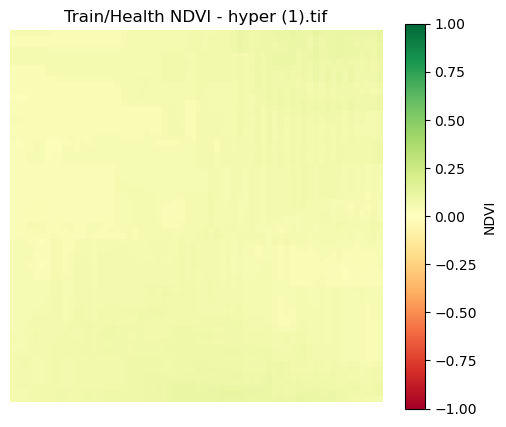

Found 200 .tif files in /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/rust. Showing up to 1 samples.
hyper (1).tif: shape (64, 64, 125)


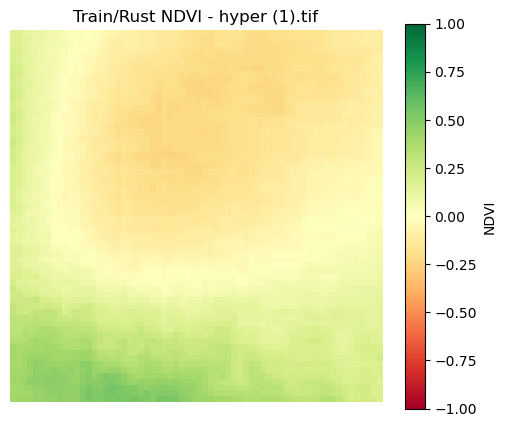

Found 200 .tif files in /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/other. Showing up to 1 samples.
hyper (1).tif: shape (64, 64, 125)


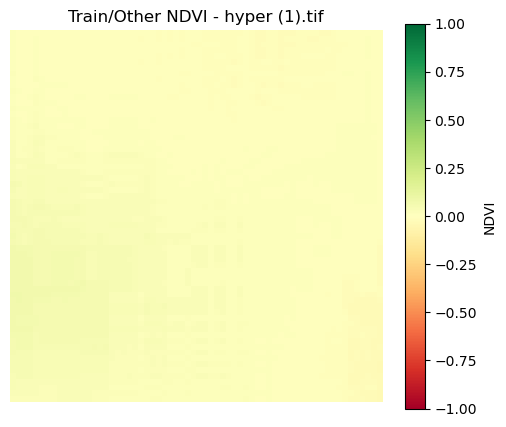

Found 300 .tif files in /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/val/val. Showing up to 1 samples.
101.tif: shape (64, 64, 125)


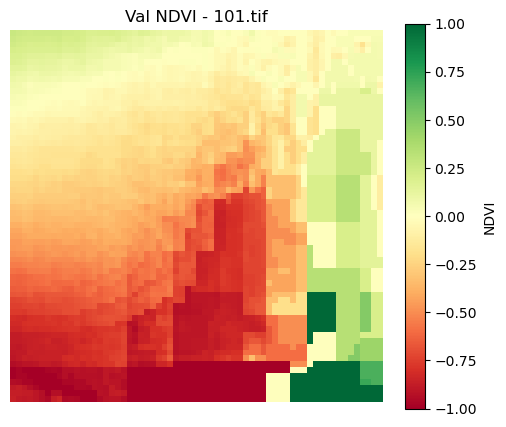

In [22]:
# Set your assumed band indices (0-based). Adjust after inspecting a sample image.
# For 4-band multispectral (B,G,R,NIR), use red=2, nir=3.
# For hyperspectral, update once you know the mapping.
RED_BAND_IDX = 2
NIR_BAND_IDX = 3

def visualize_ndvi_from_folder(folder_path, max_samples=1, title_prefix=""):
    tif_paths = sorted(glob(str(folder_path / "*.tif")))
    if len(tif_paths) == 0:
        print(f"No .tif files found in {folder_path}")
        return
    print(f"Found {len(tif_paths)} .tif files in {folder_path}. Showing up to {max_samples} samples.")
    shown = 0
    for p in tif_paths:
        img = load_tif(p)
        print(f"{Path(p).name}: shape {img.shape}")
        if img.shape[2] <= max(RED_BAND_IDX, NIR_BAND_IDX):
            print("Image has fewer bands than expected. Adjust RED/NIR indices.")
            continue
        ndvi = compute_ndvi(img, RED_BAND_IDX, NIR_BAND_IDX)

        plt.figure(figsize=(6,5))
        plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
        plt.colorbar(label="NDVI")
        plt.title(f"{title_prefix} NDVI - {Path(p).name}")
        plt.axis("off")
        plt.show()

        shown += 1
        if shown >= max_samples:
            break

# Visualize one sample from each folder
visualize_ndvi_from_folder(train_health_dir, max_samples=1, title_prefix="Train/Health")
visualize_ndvi_from_folder(train_rust_dir,   max_samples=1, title_prefix="Train/Rust")
visualize_ndvi_from_folder(train_other_dir,  max_samples=1, title_prefix="Train/Other")
visualize_ndvi_from_folder(val_dir,          max_samples=1, title_prefix="Val")

In [18]:
output_dir = base_dir / "ndvi_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

def batch_compute_and_save_ndvi(src_dir, sublabel):
    tif_paths = sorted(glob(str(src_dir / "*.tif")))
    print(f"[{sublabel}] Processing {len(tif_paths)} files from {src_dir}")
    for p in tif_paths:
        img = load_tif(p)
        if img.shape[2] <= max(RED_BAND_IDX, NIR_BAND_IDX):
            print(f"Skipping {Path(p).name} (insufficient bands).")
            continue
        ndvi = compute_ndvi(img, RED_BAND_IDX, NIR_BAND_IDX)

        # Save a PNG visualization
        out_png = output_dir / f"{sublabel}_{Path(p).stem}_ndvi.png"
        plt.figure(figsize=(6,5))
        plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
        plt.colorbar(label="NDVI")
        plt.title(f"{sublabel} NDVI - {Path(p).name}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(out_png, dpi=150)
        plt.close()

        # Optionally save NDVI as float32 .npy for later use
        out_npy = output_dir / f"{sublabel}_{Path(p).stem}_ndvi.npy"
        np.save(out_npy, ndvi.astype(np.float32))

batch_compute_and_save_ndvi(train_health_dir, "train_health")
batch_compute_and_save_ndvi(train_rust_dir,   "train_rust")
batch_compute_and_save_ndvi(train_other_dir,  "train_other")
batch_compute_and_save_ndvi(val_dir,          "val")
print("NDVI outputs saved to:", output_dir)

[train_health] Processing 200 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/health
[train_rust] Processing 200 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/rust
[train_other] Processing 200 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/other
[val] Processing 300 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/val/val
NDVI outputs saved to: /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/ndvi_outputs


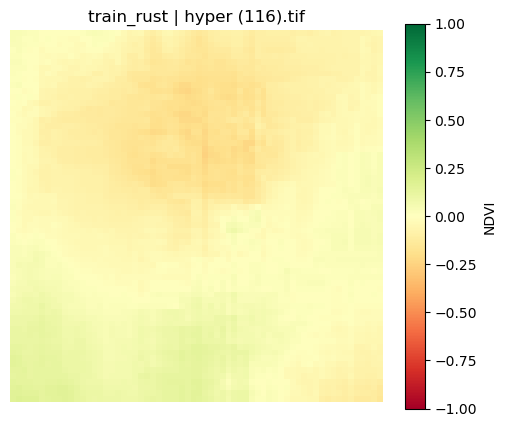

In [24]:
target_split = "train_rust"  
file_index   = 19  
RED_BAND_IDX = 2
NIR_BAND_IDX = 3

from pathlib import Path
from glob import glob
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

src_dir = {
    "train_health": base_dir / "archive" / "train" / "health",
    "train_rust":   base_dir / "archive" / "train" / "rust",
    "train_other":  base_dir / "archive" / "train" / "other",
    "val":          base_dir / "archive" / "val" / "val",
}[target_split]

tifs = sorted(glob(str(src_dir / "*.tif")))
p = Path(tifs[file_index])

img = tiff.imread(str(p))
if img.ndim == 2: img = img[..., None]
elif img.ndim == 3 and img.shape[0] < min(img.shape[1], img.shape[2]): img = np.moveaxis(img, 0, -1)

red, nir = img[:, :, RED_BAND_IDX].astype(np.float32), img[:, :, NIR_BAND_IDX].astype(np.float32)
ndvi = (nir - red) / np.clip(nir + red, 1e-6, None)
ndvi = np.clip(ndvi, -1, 1)

plt.figure(figsize=(6,5))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title(f"{target_split} | {p.name}")
plt.axis("off")
plt.show()